## Programs

Here we keep the main programs to calculate qPageRank of any directed graph.

In [1]:
import math as math
import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as lin
import numpy as np
import sympy as sym

In [2]:
pi = np.pi

##### ket_vector(n, v):

Let the graph has $n$ vertices. Corresponding to every vertex $v$ we assign a ket vector of dimension $n$. This is a binary $(0,1)$ vector. In $|n, v>$ of in short $|v>$ the $v$-th position is $1$ and the other posiitons are $0$.

This program takes $n$ and $m$ inputs and returns the $|v>$ as output.

In [3]:
def ket_vector(n, v):
    ket = [0] * n
    ket[v] = 1
    return np.matrix(ket).transpose()

##### Construction of Weyl operators

Let $G$ be a graph with $n$ vertices. Let $u_0$ be a vertex with neighbors $u_1, u_2, \dots u_d$. We can construct operators of order $n$, such that
$$U_{u_0, u_0} = I_n,$$
$$U_{u_0, u_1} = \sum_{k = 0}^{n - 1} \exp\left(\frac{2\pi \iota u_0 k}{n}\right) |k> <k \oplus u_1|$$
Similarly for the edge $(u_0, u_l)$ we have 
$$U_{u_0, u_l} = \sum_{k = 0}^{n - 1} \exp\left(\frac{2\pi \iota u_0 k}{n}\right) |k> <k \oplus u_l|,$$
where $l = 1, 2, \dots d$.

$\oplus$ is adition modulo $n$, where $n$ is the number of nodes in the graph.

In [4]:
def w_coeff(n, u_0, k):
    return(np.exp(2J*pi * u_0 * k / n))

In [5]:
def Weyl(n, u_0, u_l):
    z = np.matrix(np.zeros((n ,n)))
    for k in range(n):
        w = w_coeff(n, u_0, k)
        z = z + w * ket_vector(n, k) * ket_vector(n, (k + u_l) % n).transpose()
    return(z)

##### Make a directed graph
This program gives two opposite orientations on every edges of a given undirected graph. It returns a dictionary where the vertices of the graph are the keys. Corresponding to every vertex $v$ this dictionary contains a loop $(v,v)$ and outgoing edges $(v, u)$ from the vertex. 

In [6]:
def make_directed(G):
    V = list(G.nodes())
    Vdict = {}
    for v in V:
        E = [(v, v)]
        for u in G.neighbors(v):
            E.append((v,u))
        Vdict[v] = E
    return(Vdict)

##### Kraus ditionary

Given a graph $G$ this program returns a dictionary kdict whose keys are the oriented edges in $G$. Correponding to every oriented edge it assigns a Kraus operator. If the graph $G$ is an undirected graph this program converts it to a directed graph.

Notations:

1. $n$ = number of nodes in $G$;
2. Kraus_list = A list containing the Kraus operators corresponding to a given vertex $u_0$ in $G$;
3. Kdict = A dictionary contains the list of Kraus operators corresponding to the vertices.

In [17]:
def Kraus_dictionary(G):
    n = G.order()
    Kdict = {}
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for u_0 in list(G.nodes()):
        d = G.out_degree(u_0) + 1
        Kdict[(u_0, u_0)] = np.matrix(np.eye(n))/math.sqrt(d)
        for u_l in G.neighbors(u_0):
            Kdict[(u_0, u_l)] = Weyl(n, u_0, u_l)/math.sqrt(d)
    return(Kdict)

##### Initial state
Here we consider a scalar multiple of the identity matrices $I_n$ on every vertex which generate the initial state.
$$\rho_{init} = \frac{1}{n^2} \sum_{v \in V(G)} I_n \otimes |v><v|.$$
We do not using the above equation for our calculation. We consider a list of matrices whose entries are $\frac{I_n}{n^2}$. We update the list with time.

In [8]:
def initial_state(G):
    n = G.order()
    I = np.matrix(np.eye(n))
    list_of_density_matrices = [I/n**2]*n
    return(list_of_density_matrices)

##### Evolve without damping factor

Here $G$ is the directed graph, $IS$ is the initial state, and $T > 1$ is the time step of evolution.

1. n = number of nodes in $G$
2. V = list of nodes in $G$.
3. M = A list of matrices. Here, we copy a initial state here. In the next step we update it.
4. t time steps from 1 to T
5. L It is a list that temporarily keeps the states during evaluation for a fixed value of time $t$.
6. For every $i$ we get a vertex. After that we consider a directed edge which is coing into $u_0$. Corresponding to every directed edge there is a Kraus operator in Kdict. This operator we apply on $M[e[0]]$. Adter this operation we update L[i] terms. When all L[i] are updated it becomes the new M[i] which is used in the next step of iteration.s

The list $M$ cotains the matrices corresponding to every vertices. Their trace represents the probability of getting the walker at the vertex. This program outputs the probability of getting walker at different vertices after T steps of operations. 

In [10]:
def evolve(G, IS, T):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        for i in range(n):
            M[i] = L[i]
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
    dic = {}
    for i in range(n):
        dic[i] = P[i]
    return(dic)

##### Evolve with damping factor

Here, we add a damping factor $\alpha, 0 < \alpha < 1$ during the evolution. The walker can move any vertex from any vertex with a probability $\alpha$. Hence, we add all the matrices at different vertices with an euqal proportion and we consider this one as our damping operator. 

In [9]:
def evolve_with_damping(G, IS, T, alpha):
    n = G.order()
    V = list(G.nodes())
    M = IS.copy()
    Kdict = Kraus_dictionary(G)
    for t in range(0, T):
#         print("t = ", t)
        L = [np.matrix(np.zeros((n , n)))]*n
        for i in range(n):
            u_0 = V[i]
            E = []
            E = list(G.in_edges(u_0)) + [(u_0, u_0)]
            for e in E:
                L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
        P = []
        Dump = sum(M)
        for i in range(n):
#             M[i] = L[i]
            M[i] = alpha * L[i] + (1 - alpha) * Dump / n
            P.append(np.around(np.trace(M[i]), 4))
#         print(P)
#     dic = {}
#     for i in range(n):
#         dic[i] = P[i]
    return(P)

#### Q-rank

##### One step evaluation

This program takes a graph $G$, a real number $\alpha \in (0, 1)$ and a list of matrices $M$. If the graph $G$ is not a directed graph the program convers it to a directed graph with edge edge has two orientaions. The list $M$ consists of matices corresponding to the verties of the graph. Then, we generate a list of matrices which is generated after one step of evolution.

In [15]:
def one_step_evolution(G, alpha, M):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    L = [np.matrix(np.zeros((n , n)))]*n
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    for i in range(n):
        u_0 = V[i]
        E = []
        E = list(G.in_edges(u_0)) + [(u_0, u_0)]
        for e in E:
            L[i] = L[i] + Kdict[e] * M[e[0]] * np.conjugate(Kdict[e]).transpose()
    Dump = sum(M)
    for i in range(n):
        L[i] = alpha * L[i] + (1 - alpha) * Dump / n
    return(L)

##### Find probability from matrices

Let $M$ be a list of matrices. In a list we keep the trace of the matrices which are the probability of getting the walker at the corresponding vertices.

In [11]:
def find_probability(M):
    n = len(M)
    P = []
    for i in range(n):
        P.append(np.around(np.trace(M[i]), 4))
    return(P)

##### Q-rank

Given a graph $G$ and a damping factor $\alpha$ this program returns the Q-rank of the nodes of $G$.

In [1]:
def q_rank(G, alpha):
    n = G.order()
    V = list(G.nodes())
    Kdict = Kraus_dictionary(G)
    IS = initial_state(G)
    M = IS.copy()
    P = []
    P = find_probability(M)
    Q = [1]*n
    t = 1
    while lin.norm(np.array(P) - np.array(Q)) >= .0001:
        P = []
        P = Q
#         print(P)
        L = one_step_evolution(G, .85, M)
        Q = []
        Q = find_probability(L)
#         print(Q)
        M = []
        M = L.copy()
        t = t + 1
    dic = {}
    for i in range(n):
        dic[i] = np.around(Q[i])
    return(dic, t)

#### Page rank

##### Google Matrix
The Google matrix is defined by 
$$G = \alpha S + (1 - \alpha) e * e^t / n.$$
Here $S$ is defined by 
$$S = H + a * (1/n) e^t,$$
H is the adjacency matrix of directed graph, $e$ is all one column vector, and $a$ is a column vector whose $i$-th position is $1$ if $i$ is a dagling node otherwise $0$. Also, $\alpha$ is a damping factor.

For simplicity we first calculate the adjacency matrix of the diected graph. We divide the non-zero rows by the out-degree of the corresponding node. We replace the zero rows by the all one rows divided by $n$, where $n$ is the number of vertices. This is the $S$ matrix. The matrix $e * e^t$ is all one matrix of order $n$.

In the program below:
1. G = Given graph. If $G$ is not directed this program converts it to a directed graph with every edge have two orientations.
2. alpha = Given damping factor
3. n = number of vertices in $G$
4. O = all one matrix of order $n$
5. A = adjacency matrix of $G$
6. H = all zero matrix of order $n$, which acts as the initial Google matrix. we replace its rows by the corresponding rows of the adjacency matrix after deviding by the vertex out degree. Therefore, $S = H$ after line 11.
7. i is an index representing a row of the Google matrix, adjacency matrix, or a vertex in $G$

In [13]:
def Google_matrix(G, alpha):
    n = G.order()
    if type(G) == nx.classes.graph.Graph:
        G = G.to_directed()
    O = np.ones(n)
    A = nx.adjacency_matrix(G).A
    S = np.zeros((n, n))
    for i in range(n):
        if G.out_degree(i) != 0:
            d = G.out_degree(i)
            S[i] = A[i]/d
        else:
            S[i] = np.ones(n)/n
    Google = alpha * S + (1 - alpha)*O/n
    return(Google)

##### Page Rank

Given a graph $G$ and a damping factor $\alpha$, this program returns the page rank of the vertices and the number of steps required for convergence with error $.0001$. 

In [14]:
def page_rank(G, alpha):
    Google = np.matrix(Google_matrix(G, alpha))
    n = G.order()
    w = np.ones(n) / n
    v = w*Google
    t = 1
    while np.linalg.norm(w - v) >= .0001:
        w = v
        v = w*Google
        t = t + 1
    dic = {}
    v = np.array(v)[0]
    for i in range(n):
        dic[i] = v[i]
    return(dic, t)
#     return(v)

## Examples

#### An arbitrary graph

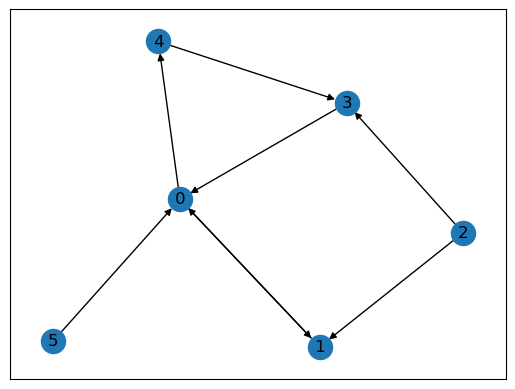

In [28]:
G=nx.DiGraph()
V = [0, 1, 2, 3, 4, 5]
E = [(0, 1), (0, 4), (1, 0), (2, 1), (2, 3), (3, 0), (4, 3), (5, 0)]
G.add_nodes_from(V)
G.add_edges_from(E)
nx.draw_networkx(G)

In [18]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_432651/3656953428.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.37648774903470544,
 1: 0.19563971512496053,
 2: 0.025,
 3: 0.1928578207153735,
 4: 0.18501471512496048,
 5: 0.025}

In [19]:
t

18

In [20]:
Q, t = q_rank(G, .85)
Q

{0: (0.3084-0j),
 1: (0.2127-0j),
 2: (0.0349-0j),
 3: (0.2051+0j),
 4: (0.1955-0j),
 5: (0.0435-0j)}

In [22]:
t

12

In [23]:
P1 = np.real(list(P.values()))
P1

array([0.37648775, 0.19563972, 0.025     , 0.19285782, 0.18501472,
       0.025     ])

In [24]:
Q1 = np.real(list(Q.values()))
Q1

array([0.3084, 0.2127, 0.0349, 0.2051, 0.1955, 0.0435])

In [25]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5]

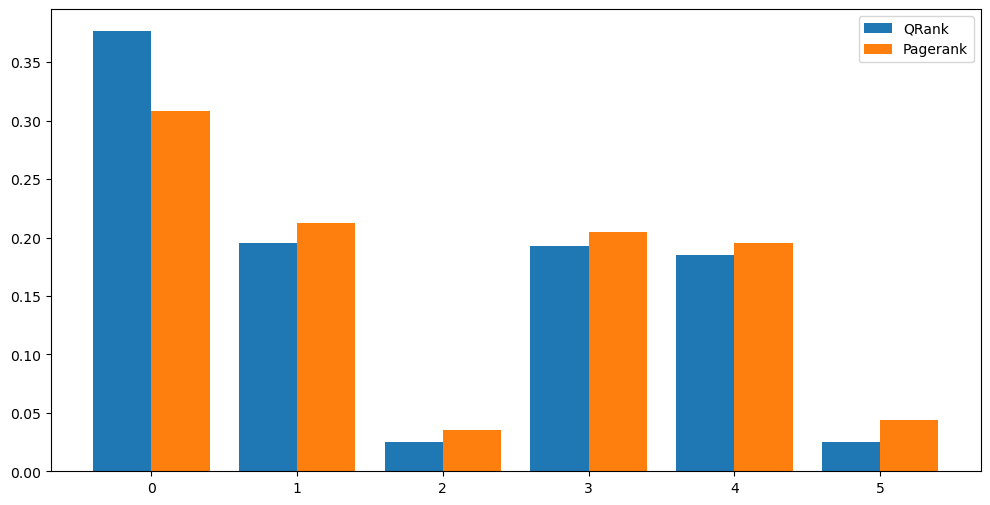

In [26]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 

##### For which value of damping factor the ranks are closest?

In [41]:
Alpha = np.linspace(0, .99, 20)
Alpha

array([0.        , 0.05210526, 0.10421053, 0.15631579, 0.20842105,
       0.26052632, 0.31263158, 0.36473684, 0.41684211, 0.46894737,
       0.52105263, 0.57315789, 0.62526316, 0.67736842, 0.72947368,
       0.78157895, 0.83368421, 0.88578947, 0.93789474, 0.99      ])

In [43]:
dicP, t = page_rank(G, 0)
P = np.array(list(dicP.values()))
dicQ, t = q_rank(G, 0)
Q = np.array(list(dicQ.values()))
diff = lin.norm(np.array(P) - np.array(Q))
A = 0
B = 0
for alpha in Alpha:
    dicP, t = page_rank(G, alpha)
    temp_P = np.array(list(dicP.values()))
    for beta in Alpha:
        dicQ, t = q_rank(G, beta)
        temp_Q = np.array(list(dicP.values()))
        temp_diff = lin.norm(np.array(P) - np.array(Q))
        if temp_diff < diff:
            diff = temp_diff
            A = alpha
            B = beta
print("difference = ", temp_diff, "alpha = ", alpha, "beta = ", beta)

/tmp/ipykernel_230045/3656953428.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


difference =  0.23884800606243295 alpha =  0.99 beta =  0.99


In [46]:
DIFF = []
for alpha in Alpha:
    dicP, t = page_rank(G, alpha)
    temp_P = np.array(list(dicP.values()))
    for beta in Alpha:
        dicQ, t = q_rank(G, beta)
        temp_Q = np.array(list(dicP.values()))
        temp_diff = lin.norm(np.array(P) - np.array(Q))
        DIFF.append((alpha, beta, temp_diff))
DIFF

/tmp/ipykernel_230045/3656953428.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


[(0.0, 0.0, 0.23884800606243295),
 (0.0, 0.05210526315789474, 0.23884800606243295),
 (0.0, 0.10421052631578948, 0.23884800606243295),
 (0.0, 0.1563157894736842, 0.23884800606243295),
 (0.0, 0.20842105263157895, 0.23884800606243295),
 (0.0, 0.2605263157894737, 0.23884800606243295),
 (0.0, 0.3126315789473684, 0.23884800606243295),
 (0.0, 0.36473684210526314, 0.23884800606243295),
 (0.0, 0.4168421052631579, 0.23884800606243295),
 (0.0, 0.46894736842105267, 0.23884800606243295),
 (0.0, 0.5210526315789474, 0.23884800606243295),
 (0.0, 0.5731578947368421, 0.23884800606243295),
 (0.0, 0.6252631578947369, 0.23884800606243295),
 (0.0, 0.6773684210526316, 0.23884800606243295),
 (0.0, 0.7294736842105263, 0.23884800606243295),
 (0.0, 0.781578947368421, 0.23884800606243295),
 (0.0, 0.8336842105263158, 0.23884800606243295),
 (0.0, 0.8857894736842106, 0.23884800606243295),
 (0.0, 0.9378947368421053, 0.23884800606243295),
 (0.0, 0.99, 0.23884800606243295),
 (0.05210526315789474, 0.0, 0.238848006062432

##### Erdos Renyi directed graph

In [74]:
G = nx.erdos_renyi_graph(10, .2, seed = None, directed = True)

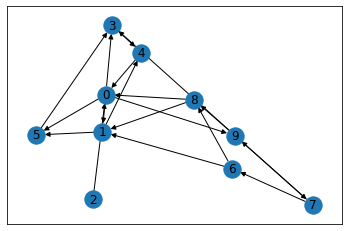

In [75]:
nx.draw_networkx(G)

In [76]:
P, t = page_rank(G, .85)
P

/tmp/ipykernel_6853/3656953428.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).A


{0: 0.21977386664497933,
 1: 0.09598558199997685,
 2: 0.015000000000000012,
 3: 0.1707763035634815,
 4: 0.20095838484237566,
 5: 0.1025019116507266,
 6: 0.030696239619291216,
 7: 0.03693324788716835,
 8: 0.049977343533978716,
 9: 0.07739712025802235}

In [77]:
t

15

In [78]:
Q, t = q_rank(G, .85)
Q

{0: (0.1586+0j),
 1: (0.0953+0j),
 2: (0.0261-0j),
 3: (0.1868+0j),
 4: (0.2111-0j),
 5: (0.1199-0j),
 6: (0.0372-0j),
 7: (0.0411+0j),
 8: (0.0558+0j),
 9: (0.0681+0j)}

In [79]:
t

14

In [80]:
P1 = np.real(list(P.values()))
P1

array([0.21977387, 0.09598558, 0.015     , 0.1707763 , 0.20095838,
       0.10250191, 0.03069624, 0.03693325, 0.04997734, 0.07739712])

In [81]:
Q1 = np.real(list(Q.values()))
Q1

array([0.1586, 0.0953, 0.0261, 0.1868, 0.2111, 0.1199, 0.0372, 0.0411,
       0.0558, 0.0681])

In [82]:
X = list(G.nodes())
X

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

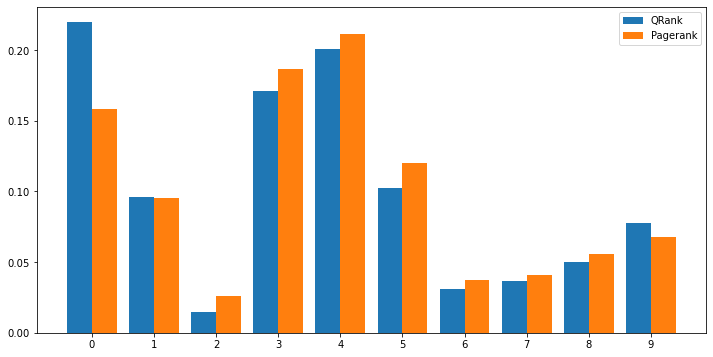

In [83]:
plt.figure(figsize=(12,6))
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, P1, 0.4, label = 'QRank') 
plt.bar(X_axis + 0.2, Q1, 0.4, label = 'Pagerank')
plt.xticks(X_axis, X) 
plt.legend() 
plt.show() 